# Specifying when it is a 'Golden Cross' or a 'Death Cross' using the moving average

In [3]:
# Importing yahoo finance library
from yahoo_fin.stock_info import get_data, tickers_sp500, tickers_nasdaq, tickers_other, get_quote_table

# Data manipulation and visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models and data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter, argrelmin, argrelmax
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb
from finta import TA
import datetime

%matplotlib inline

# Getting stock data from yahoo fin

In [20]:
# Getting stock data
df = get_data('acrx')

# Dropping the name column
df.drop('ticker',axis=1, inplace=True)

# Calculating the slow wma
slow = TA.WMA(df, 50)

# Calculating the fast wma
fast = TA.WMA(df, 200)

# Ading the information back to the Data Frame
df['Fast_WMA'] = fast
df['Slow_WMA'] = slow

# Dropping null values
df.dropna(inplace=True)

# Calculating a one when the fast and the slow wma cross
cross_over = 'Death_Cross'
df[cross_over] = 0

# Classifying when its a cross over

In [21]:
df[cross_over].loc[df['Slow_WMA'] < df['Fast_WMA']] = 1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Breaking up my target and features to fit into a logreg model

In [64]:
max_cols = [c for c in df.columns.tolist() if c not in [cross_over]]
X, y = df[max_cols].values, df.Death_Cross.values

logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=250, penalty='l1', solver = 'liblinear')

scores = cross_val_score(logreg, X, y, cv=6)
scores.mean(), scores.std()

(0.9600300801302751, 0.05609436575543586)

In [66]:
# Getting the predictions feom my model
predictions = cross_val_predict(logreg, X, y, cv=6)

In [67]:
# Adding them back to my data frame
df['Predictions'] = predictions

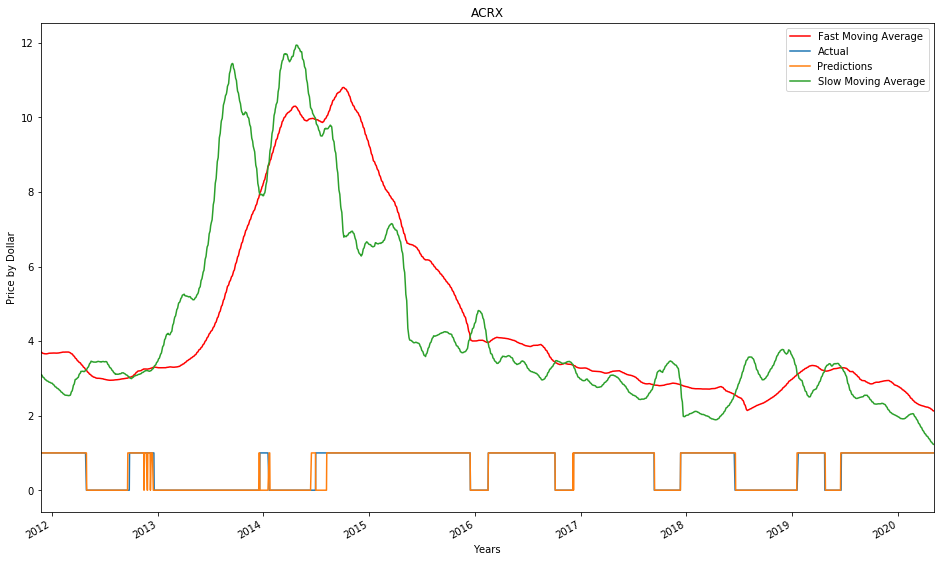

In [68]:
# Plotting out my predictions and actual data
df.Fast_WMA.plot(color='r', label='Fast Moving Average')
df.Death_Cross.plot(label='Actual')
df.Predictions.plot(label='Predictions')
df.Slow_WMA.plot(label='Slow Moving Average', figsize=(16,10))
plt.title('ACRX')
plt.xlabel('Years')
plt.ylabel('Price by Dollar')
plt.legend();

In [31]:
pchange = df.close.pct_change(5).shift(-5)
target = (pchange > 0.10).astype(np.int)

In [32]:
pchange

2011-11-25   -0.017241
2011-11-28   -0.037801
2011-11-29   -0.055556
2011-11-30   -0.083612
2011-12-01   -0.058419
                ...   
2020-04-28         NaN
2020-04-29         NaN
2020-04-30         NaN
2020-05-01         NaN
2020-05-04         NaN
Name: close, Length: 2122, dtype: float64